In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import DenseNet201
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt









In [3]:
# Constants
image_directory = 'Training/'
class_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
INPUT_SIZE_DENSENET = (224, 224)

# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Load and preprocess data
dataset = []
labels = []

In [4]:

for folder in class_folders:
    folder_path = os.path.join(image_directory, folder)
    if os.path.exists(folder_path):
        images = os.listdir(folder_path)
        print(f"Found {len(images)} images in {folder} folder.")
    else:
        print(f"Directory {folder_path} does not exist.")
        continue

    for image_name in images:
        if image_name.split('.')[-1].lower() not in ['jpg', 'jpeg']:
            continue

        image_path = os.path.join(folder_path, image_name)
        try:
            image = cv2.imread(image_path)
            if image is None or image.size == 0 or image.shape[0] == 0 or image.shape[1] == 0:
                print(f"Error or invalid image: {image_path}")
                continue

            image = Image.fromarray(image, 'RGB')
            image = image.resize((INPUT_SIZE_DENSENET[0], INPUT_SIZE_DENSENET[1]))
            image = np.array(image)
            image = preprocess_input(image)

            dataset.append(image)
            labels.append(folder)

            # Apply data augmentation
            for augmented_image, _ in zip(datagen.flow(np.expand_dims(image, axis=0), batch_size=8), range(1)):
                dataset.append(augmented_image[0])
                labels.append(folder)

        except cv2.error as e:
            print(f"OpenCV error: {e} for image: {image_path}")

Found 1321 images in glioma folder.
Found 1339 images in meningioma folder.
Found 1595 images in notumor folder.
Found 1457 images in pituitary folder.


In [5]:
# Convert labels to numeric representation
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, numeric_labels, test_size=0.2, random_state=42)

# Create a DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE_DENSENET[0], INPUT_SIZE_DENSENET[1], 3))

# Build a model on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_folders), activation='softmax')
])

# Use a lower learning rate
optimizer = Adam(learning_rate=0.0001)


In [6]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Use ImageDataGenerator for data augmentation on training data
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No data augmentation on test data
test_datagen = ImageDataGenerator()

# Train data generator
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=32, shuffle=True)

# Test data generator
test_generator = test_datagen.flow(np.array(X_test), y_test, batch_size=32, shuffle=False)

In [7]:
# Define Early Stopping callback
e_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model using the generator
history = model.fit(
    train_generator,
    epochs=5,  
    validation_data=test_generator,
    callbacks=[e_stopping],
    verbose=1
)

Epoch 1/5


286/286 [==============================] - 4495s 15s/step - loss: 0.6822 - accuracy: 0.7740 - val_loss: 0.1804 - val_accuracy: 0.9322
Epoch 2/5
286/286 [==============================] - 4264s 15s/step - loss: 0.2919 - accuracy: 0.9052 - val_loss: 0.0926 - val_accuracy: 0.9619
Epoch 3/5
286/286 [==============================] - 4264s 15s/step - loss: 0.1977 - accuracy: 0.9370 - val_loss: 0.1361 - val_accuracy: 0.9549
Epoch 4/5
286/286 [==============================] - 4382s 15s/step - loss: 0.1689 - accuracy: 0.9461 - val_loss: 0.0907 - val_accuracy: 0.9650
Epoch 5/5
286/286 [==============================] - 4713s 16s/step - loss: 0.1378 - accuracy: 0.9544 - val_loss: 0.0640 - val_accuracy: 0.9799


72/72 [==============================] - 296s 4s/step - loss: 0.0640 - accuracy: 0.9799
Test Accuracy: 0.9798687100410461
72/72 [==============================] - 307s 4s/step
Confusion Matrix:
 [[545   5   5   0]
 [ 16 542   3   4]
 [  0   1 597   0]
 [  2   7   3 555]]
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       555
  meningioma       0.98      0.96      0.97       565
     notumor       0.98      1.00      0.99       598
   pituitary       0.99      0.98      0.99       567

    accuracy                           0.98      2285
   macro avg       0.98      0.98      0.98      2285
weighted avg       0.98      0.98      0.98      2285



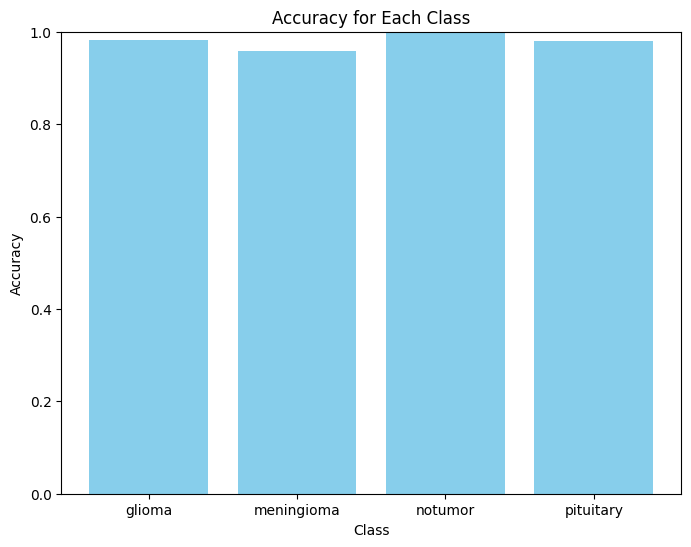

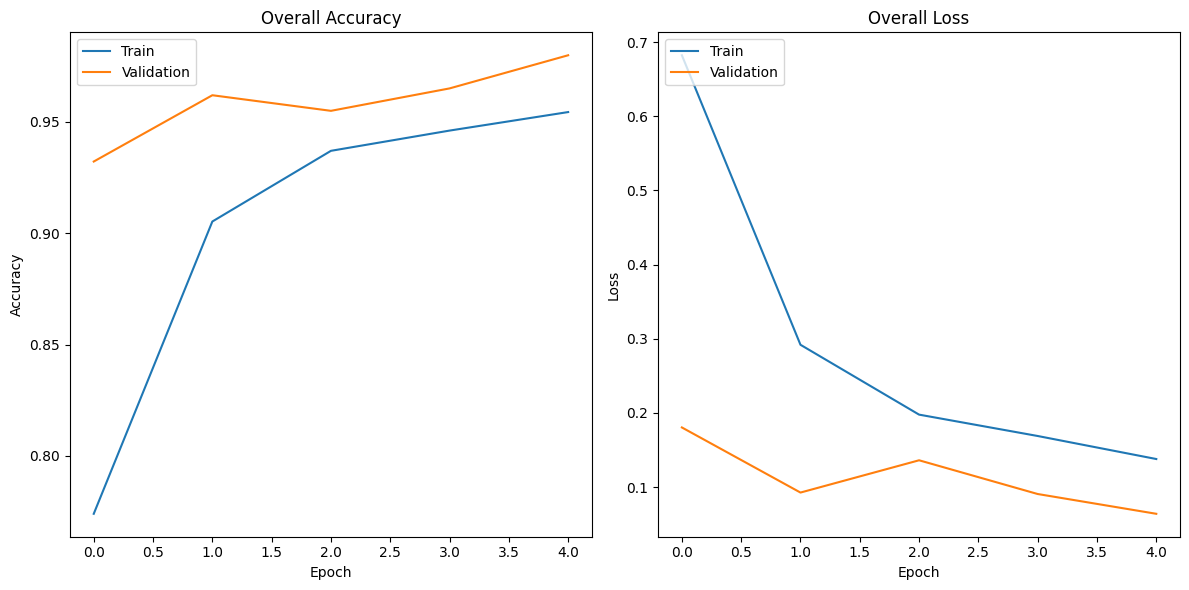

In [8]:
# Plot training history
model.save('BrainTumorModel2.keras')

# ... (rest of the code)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test Accuracy: {test_accuracy}')

# Save the model


# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=class_folders)
print("Classification Report:\n", class_report)

# Plot accuracy for each class

def plot_accuracy(y_true, y_pred_classes, class_folders):
    plt.figure(figsize=(8, 6))

    # Calculate accuracy for each class
    class_accuracy = [accuracy_score(y_true[y_true == i], y_pred_classes[y_true == i]) for i in range(len(class_folders))]

    # Plot bar chart
    plt.bar(class_folders, class_accuracy, color='skyblue')
    plt.title('Accuracy for Each Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy

    plt.show()

# Plot accuracy for each class
plot_accuracy(y_test, y_pred_classes, class_folders)

# Plot overall accuracy and loss
def plot_overall_accuracy_loss(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Overall Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Overall Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot overall accuracy and loss
plot_overall_accuracy_loss(history)

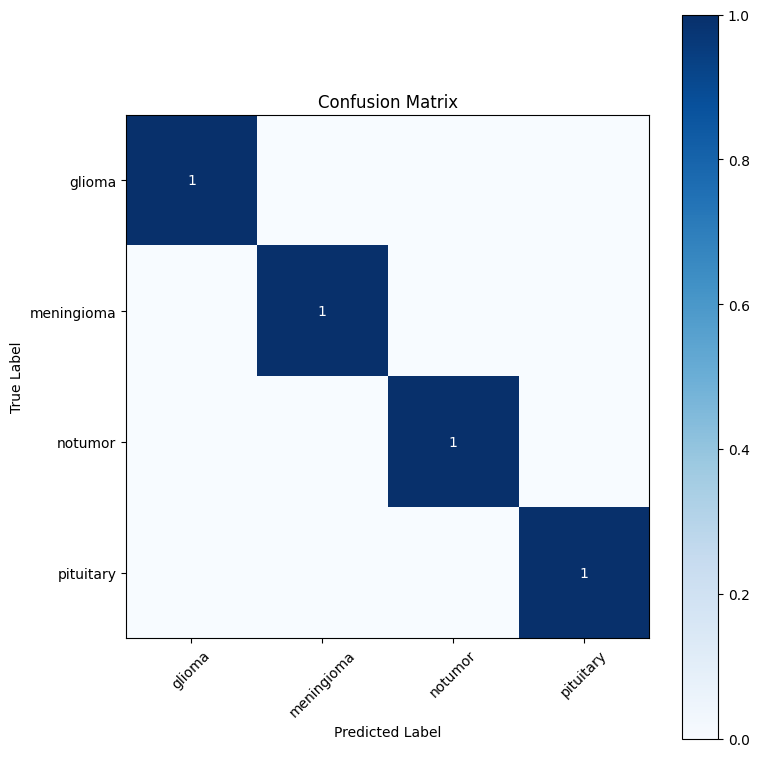

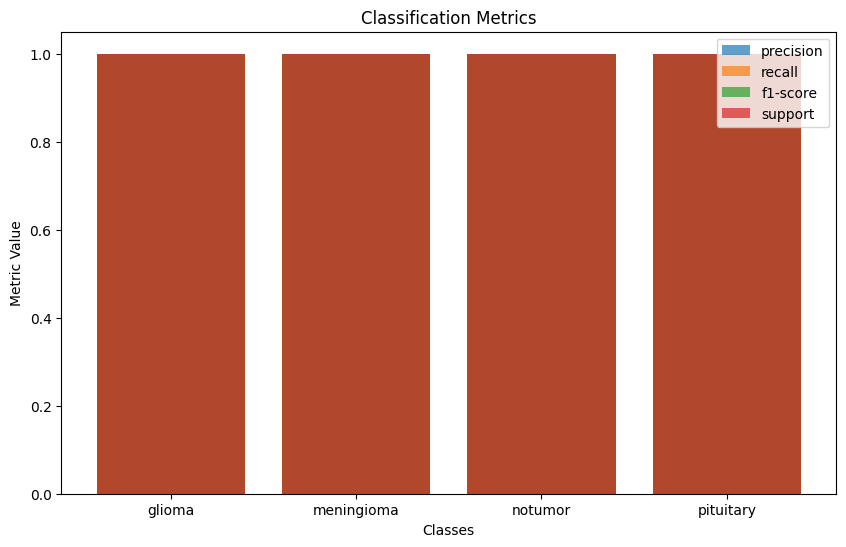

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Example data (replace with your actual data)
true_labels = ["glioma", "meningioma", "notumor", "pituitary"]
predicted_labels = ["glioma", "meningioma", "notumor", "pituitary"]
cm_data = np.array([[545, 5, 5, 0],
                    [16, 542, 3, 4],
                    [0, 1, 597, 0],
                    [2, 7, 3, 555]])

def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_classification_metrics(classification_report):
    metrics = ['precision', 'recall', 'f1-score', 'support']
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    data = []
    for metric in metrics:
        values = [float(classification_report[class_name][metric]) for class_name in classes]
        data.append(values)

    data = np.array(data)

    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        plt.bar(classes, data[i, :], label=metric, alpha=0.7)

    plt.title('Classification Metrics')
    plt.xlabel('Classes')
    plt.ylabel('Metric Value')
    plt.legend(loc='upper right')
    plt.show()

# Plotting confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, classes=true_labels)

# Plotting classification metrics
classification_rep = classification_report(true_labels, predicted_labels, target_names=true_labels, output_dict=True)
plot_classification_metrics(classification_rep)


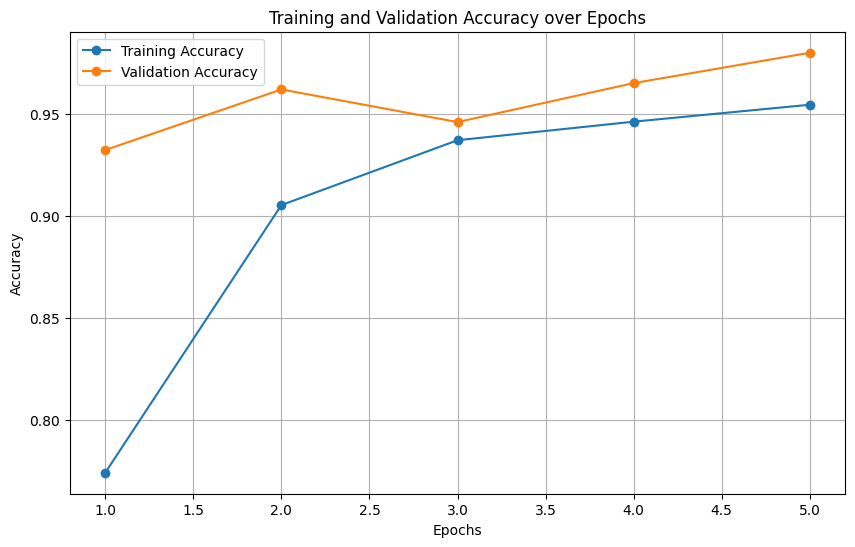

In [6]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
epochs = range(1, 6)  # Assuming 72 epochs based on your results
training_accuracy = [0.7740,0.9052,0.9370,0.9461,0.9544]  # Replace with your training accuracy values
validation_accuracy = [0.9322,0.9619,0.9459,0.9650,0.9799]  # Replace with your validation accuracy values

# Ensure both accuracy lists have the same length as epochs
assert len(epochs) == len(training_accuracy) == len(validation_accuracy), "Length mismatch"

# Plotting training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


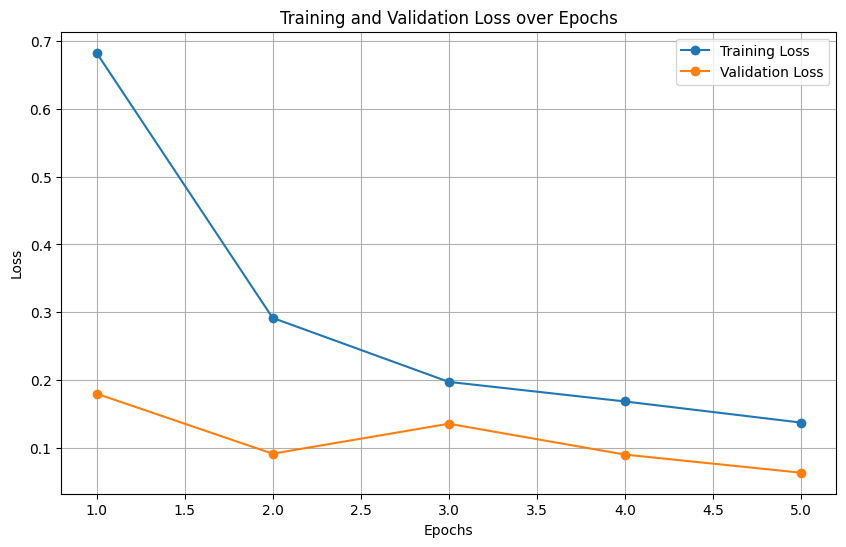

In [10]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
epochs = range(1, 6)  # Assuming 72 epochs based on your results
training_loss = [0.6822,0.2919,0.1977,0.1689,0.1378]  # Replace with your training loss values
validation_loss = [0.1804,0.0920,0.1361,0.0907,0.0640]  # Replace with your validation loss values

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
